# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.figures.figure2 import plotR2YQ2Y, plotKmeansPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, clusteraverages
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC_mc = preprocess_seqs(ABC_mc, "Y")


header = ABC_mc.columns
treatments = ABC_mc.columns[3:13]

data = ABC_mc.iloc[:,3:13].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

In [3]:
ABC_mc.sort_values(by="Master Protein Descriptions")

,peptide-phosphosite,Master Protein Descriptions,Master_Protein_Accessions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428,position
205,KtTLLyKLKGH,ADP-ribosylation factor-like protein 11,Q969Q4,0.436124,0.131374,0.231937,-0.632018,0.247047,-0.182625,-0.056898,-0.099946,-0.004437,-0.070557,Y30-p
268,PKDSDyYNMLL,AP-2 complex subunit beta,P63010,0.232813,0.180745,0.212709,0.337330,0.318657,0.289776,0.435203,-0.430493,-0.742926,-0.833813,Y276-p
382,TVPNDyMTSPA,Abl interactor 1,Q8IZP0,-0.542414,-0.750213,-1.283328,0.034151,-0.018869,0.254136,0.836933,0.310547,0.650721,0.508335,Y213-p
345,SPDHLySFRIL,Actin filament-associated protein 1-like 2,Q8N4X5,0.371200,-0.080439,0.164508,-0.036282,0.110206,0.236999,0.113010,-0.095493,-0.134613,-0.649097,Y413-p
167,ISKQEyDESGP,"Actin, cytoplasmic 1",P60709,2.202816,0.681520,0.903752,-0.545238,-0.194689,-0.850954,-0.065305,-0.813186,-0.520589,-0.798127,Y362-p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,LDNGGyYITTR,Tyrosine-protein kinase Yes,P07947,0.053595,0.339576,0.141457,-0.430599,0.530266,0.079684,0.266545,0.193062,-0.200309,-0.973278,Y222-p
185,KKETRyGEVFE,Tyrosine-protein kinase receptor UFO,P30530,0.477052,0.653013,1.342190,0.862978,0.693307,0.717566,0.796643,-1.843223,-1.709258,-1.990268,Y481-p
352,SRVQIyHNPTA,Vasodilator-stimulated phosphoprotein,P50552,0.858677,0.339039,0.175984,-0.215963,0.098256,0.041325,-0.200472,-0.296608,-0.065970,-0.734269,Y39-p
166,INRMDyVEINI,Vigilin,Q00341,-0.210772,-1.350055,-0.560998,0.065785,-0.264265,-0.583999,1.222372,0.066240,1.714528,-0.098834,Y437-p


### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

## 1. Cross-validation

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [5]:
ncl = 2

In [6]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

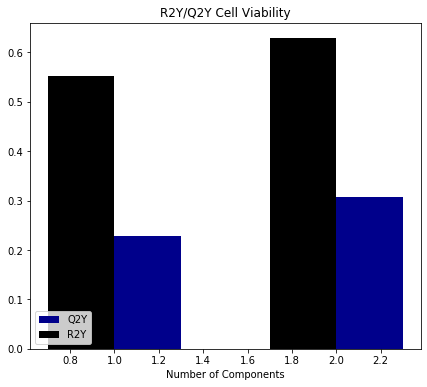

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [8]:
# fig, ax = plt.subplots(1, 1)
# plotKmeansPLSR_GridSearch(ax, data, Y_cv)

In [9]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)

In [10]:
# CVresults_min.sort_values(by="Ranking").iloc[:20, :]

## 2. Model Predicted vs Actual for best Hyperparameter Set

In [11]:
ncl, ncomp = 2, 2

### 2.1 With CV Strategy 1:

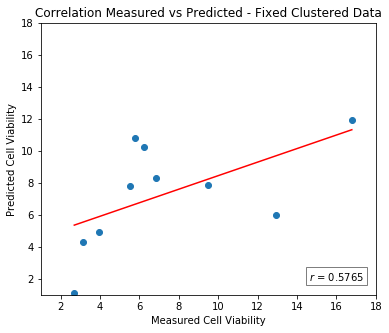

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plotMeasuredVsPredicted(ax, PLSRegression(ncomp), centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

### 2.2 With CV Strategy 2:

In [13]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [14]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

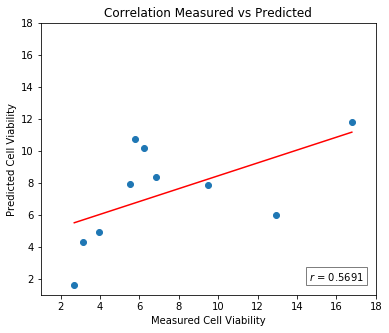

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, kmeans_plsr, data, Y_cv)

## 3. PLSR scores and loadings 

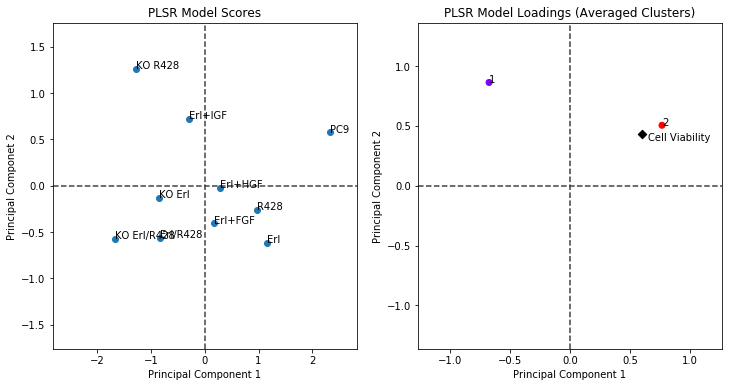

In [16]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Componet 2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([(-1*max(PC1_scores))-0.5, max(PC1_scores)+0.5])
axs[0].set_ylim([(-1*max(PC2_scores))-0.5, max(PC2_scores)+0.5])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].annotate("Cell Viability", (PC1_yload+0.05, PC2_yload-0.05))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([(-1*max(PC1_xload))-0.5, max(PC1_xload)+0.5])
axs[1].set_ylim([(-1*max(PC2_xload))-0.5, max(PC2_xload)+0.5]);

In [17]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,ProtAcc_Cluster_1,pos_Cluster_1,Cluster_2,seqs_Cluster_2,ProtAcc_Cluster_2,pos_Cluster_2
0,Pyruvate kinase PKM,AEAAIyHLQLF,P14618,Y390-p,Protein-glutamine gamma-glutamyltransferase 2,AERDLyLENPE,P21980,Y583-p
1,Ras and Rab interactor 1,AQDPLyDVPNA,Q13671,Y36-p,Transgelin-2,AGMTGyGMPRQ,P37802,Y192-p
2,Receptor tyrosine-protein kinase erbB-3,ASEQGyEEMRA,P21860,Y1289-p,Aldo-keto reductase family 1 member B1,AIDVGyRHIDC,P15121,Y40-p
3,Homeodomain-interacting protein kinase 2,AVCSTyLQSRY,Q9H2X6,Y361-p,Receptor tyrosine-protein kinase erbB-3,APHVHyARLKT,P21860,Y1307-p
4,Eukaryotic translation initiation factor 3 sub...,DTLSIyETPSM,P55884,Y449-p,Homeodomain-interacting protein kinase 1,AVCSTyLQSRY,Q86Z02,Y352-p
5,Ephrin type-B receptor 3,EKLQQyIAPGM,P54753,Y600-p,Catenin beta-1,AVRLHyGLPVV,P35222,Y489-p
6,Epidermal growth factor receptor kinase substr...,EKPRQyHEQEE,Q12929,Y252-p,"Keratin, type II cytoskeletal 7",AVRsAyGGPVG,P08729,Y55-p
7,Rho GTPase-activating protein 35,FDPSDyAEPMD,Q9NRY4,Y1087-p,Retinoic acid-induced protein 3,AWPSPyKDYEV,Q8NFJ5,Y347-p
8,Mitogen-activated protein kinase 10,FMMTPyVVTRY,P53779,Y223-p,Annexin A2,DARDLyDAGVK,P07355,Y199-p
9,Mitogen-activated protein kinase 8,FMMTPyVVTRY,P45983,Y185-p,Cofilin-1,DKDCRyALYDA,P23528,Y82-p


#### Cluster Averages across Conditions

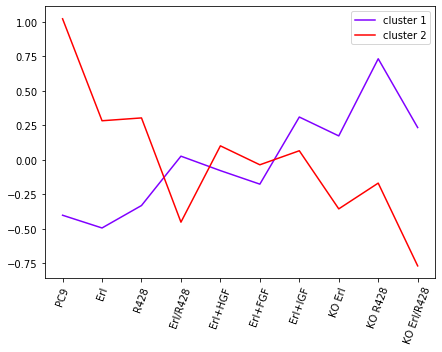

In [18]:
fig = plt.figure(figsize=(7,5))

centers = kmeans_plsr.named_steps.kmeans.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);